# NLP Exercise 1

#### by Carina Hausladen / 7344284

In [1]:
# Define local path of the RDRPOSTagger Repo (see: https://github.com/jacopofar/RDRPOSTagger-python-3)

# RDRPOS_PATH = r'C:\Users\carin\Desktop\NLP\RDRPOSTagger'
RDRPOS_PATH = r'C:\carina\RDRPOSTagger'

In [2]:
import os 
import sys

import pprint 
import nltk
from nltk import word_tokenize, pos_tag

import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

from nltk.corpus import brown, conll2002
from nltk import DefaultTagger as df
from nltk import UnigramTagger as ut
from nltk import BigramTagger as bt
from nltk import TrigramTagger as tg

In [3]:
pretrained = nltk.data.load('taggers/maxent_treebank_pos_tagger/english.pickle')

def features(sentence, index):
    return {
        'word': sentence[index],
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'prefix-1': sentence[index][0],
        'suffix-1': sentence[index][-1],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1]
    }

def my_features(sentence, index): # optimized feature extraction
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }

def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]

def transform_to_dataset(tagged_sentences, use_optimized=True):
    X, y = [], []
    for tagged in tagged_sentences:
        for index in range(len(tagged)):
            X.append(my_features(untag(tagged), index) if use_optimized else features(untag(tagged), index))
            y.append(tagged[index][1])
 
    return X, y

# Task 1

In [4]:
corpus_list = [nltk.corpus.treebank,
               nltk.corpus.brown ]  
name_list = ['1.1', '1.2', '1.3.1', '1.3.2', '1.3.3', '1.3.4', '1.3.5', '1.4', '1.5', '1.6.1', '1.6.2', '1.6.3', '1.6.4', '1.6.5']
accuracies = []

for corpus in corpus_list:
    #split in training and test 
    annotated_sent = corpus.tagged_sents()
    cutoff = int(.75 * len(annotated_sent))
    training_sentences = annotated_sent[:cutoff] #0.8
    test_sentences = annotated_sent[cutoff:] #0.2
    
    #create dataset
    X, y = transform_to_dataset(training_sentences)

    ##########################
    #Model 1
    ##########################
    size=10000
    clf = Pipeline([
        ('vectorizer', DictVectorizer(sparse=False)),
        ('classifier', DecisionTreeClassifier(criterion='entropy')) #OTHER OPTIONS: Hidden Markov Model, Logistic Regression, Maximum Entropy Markov Models, Decision Trees, Naive Bayes
    ])

    clf.fit(X[:size], y[:size]) #the classifier learns from the training data
    X_test, y_test = transform_to_dataset(test_sentences) #this function uses my features
    accuracies.append(clf.score(X_test, y_test)) 
    
    #######################
    #Model 2
    #######################
    accuracies.append(pretrained.evaluate(training_sentences))

    ##########################
    #Model 3.x
    ##########################
    patterns = [(r'.*ing$', 'VBG'), (r'.*ed$', 'VBD'), (r'.*es$', 'VBZ'), (r'.*ould$', 'MD'), (r'.*\'s$', 'NN$'),               
                 (r'.*s$', 'NNS'), (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), (r'.*', 'NN')]
    
    def_model       = nltk.DefaultTagger('NN') #backoff: when a more powerful tagger is unable to assign a tag to the word
    uni_model       = nltk.UnigramTagger(training_sentences)
    bi_model        = nltk.BigramTagger(training_sentences)
    tri_model       = nltk.TrigramTagger(training_sentences)
    regexp_model    = nltk.RegexpTagger(patterns)
    
    accuracies.append(def_model.evaluate(test_sentences))
    accuracies.append(uni_model.evaluate(test_sentences))
    accuracies.append(bi_model.evaluate(test_sentences))
    accuracies.append(tri_model.evaluate(test_sentences))
    accuracies.append(regexp_model.evaluate(test_sentences))

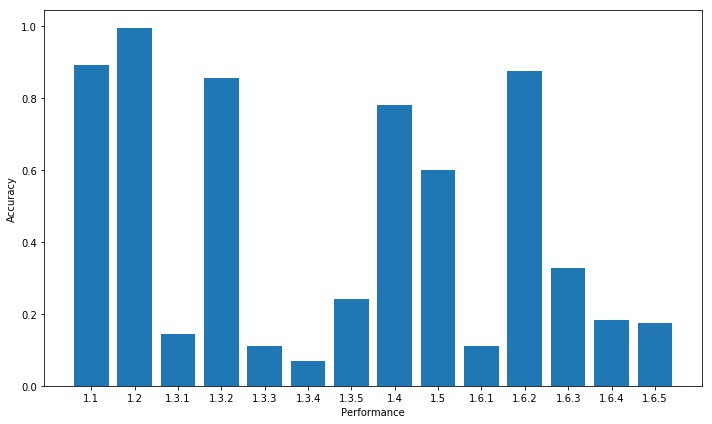

In [5]:
plt.rcParams["figure.figsize"] = [10,6]
fig, ax = plt.subplots()
index = np.arange(len(name_list))
y = ax.bar(index, accuracies)
ax.set_xlabel('Performance')
ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(len(name_list)))
ax.set_xticklabels(name_list)
fig.tight_layout()

plt.show()

## Task 2

### Prepare X3 

In [6]:
X3= nltk.corpus.conll2002
name_list = ['2.1', '2.2']
accuracies2 = []

#split in training and test 
annotated_sent = X3.tagged_sents('ned.testa') #dutch and spanish, only use dutch
cutoff = int(.75 * len(annotated_sent))
training_sentences = annotated_sent[:cutoff] #0.8
test_sentences = annotated_sent[cutoff:] #0.2

### Model 4

In [7]:
X, y = transform_to_dataset(training_sentences, use_optimized=False) # use standard features

size=10000
clf = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', DecisionTreeClassifier(criterion='entropy')) #OTHER OPTIONS: Hidden Markov Model, Logistic Regression, Maximum Entropy Markov Models, Decision Trees, Naive Bayes
])

clf.fit(X[:size], y[:size]) #the classifier learns from the training data
X_test, y_test = transform_to_dataset(test_sentences) #this function uses my features
accuracies2.append(clf.score(X_test, y_test)) 

### Model 5

In [8]:
os.chdir(RDRPOS_PATH + '\pSCRDRtagger')
sys.path.insert(0, RDRPOS_PATH + '\pSCRDRtagger')

import RDRPOSTagger as rpt
import nltk

def tagged_tuples(tagged_str):
    tagged_tuples = []
    for t in tagged_str.split():
        x, y = t.split('/')
        tagged_tuples.append((x,y))
    
    return tagged_tuples

def readDictionary2(inputFile): #change to utf8 encoding
    dictionary = {}
    lines = open(inputFile, encoding= "utf8").readlines()
    for line in lines:
        wordtag = line.strip().split()
        dictionary[wordtag[0]] = wordtag[1]
    return dictionary

In [9]:
r = rpt.RDRPOSTagger()
r.constructSCRDRtreeFromRDRfile(RDRPOS_PATH + r"\Models\MORPH\Dutch.RDR")
DICT = readDictionary2(RDRPOS_PATH + r"\Models\MORPH\Dutch.DICT")

['Node', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'tabStr']


In [10]:
def transform_to_dataset(tagged_sentences, use_optimized=True):
    X, y = [], []
    for tagged in tagged_sentences:
        for index in range(len(tagged)):
            X.append(features(untag(tagged), index))
            y.append(tagged[index][1])
 
    return X, y

In [11]:
#choose corpus
tagged_sents    = X3.tagged_sents('ned.testa')
sents           = X3.sents('ned.testa')
text = [' '.join(i) for i in sents]
text = ' '.join(text)

tagged_text = r.tagRawSentence(DICT, text)  #use the RDRPOS tagger

tagged_tuples = []
for t in tagged_text.split():
    tup = t.split('/')
    if len(tup) >= 3:  # drop data with more than 3 entries
        continue
    else:
        tup = tuple(tup)
    tagged_tuples.append(tup)
    
#convert tuples to list
list_of_lists = [list(elem) for elem in tagged_tuples]

#Change appearance of the tag
for i in range(len(list_of_lists)): 
    str = list_of_lists[i][1]
    temp = str.split(".",1)
    temp2 = temp[1].split("(",1)
    list_of_lists[i][1]= temp2[0]
    
#convert back to tuples
tagged_tuples = [tuple(l) for l in list_of_lists]

predicted_tuples = [tagged_tuples]

#get accuracy
X_pred, y_pred = transform_to_dataset(predicted_tuples, use_optimized=False)
X, y = transform_to_dataset(tagged_sents, use_optimized=False)
total_count = len(y_pred)
match_count = 0

for i in range(total_count):
    if y[i] == y_pred[i]:
        match_count = match_count + 1
    
print(match_count * 1.0/total_count)
    
accuracies2.append(match_count * 1.0/total_count)

0.06255478524185194


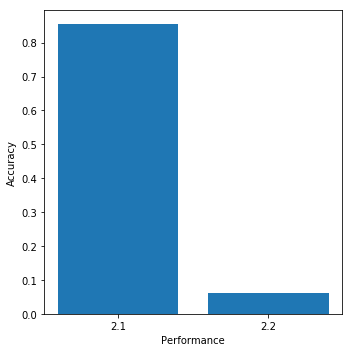

In [12]:
plt.rcParams["figure.figsize"] = [5,5]
fig, ax = plt.subplots()
index = np.arange(len(name_list))
y = ax.bar(index, accuracies2)
ax.set_xlabel('Performance')
ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(len(name_list)))
ax.set_xticklabels(name_list)
fig.tight_layout()

plt.show()